Process for prepping a SafeGraph zip file:

In [2]:
import pandas as pd
import datetime as dt
import timedelta
import os 
import numpy as np
path = r'C:\Users\nelms\Documents\Penn\MUSA-508\MUSA508_FINAL_SFPARK'
os.chdir(path)

final_cols = ['trans_id','time','action']
pull_cols = ['meter_id', 'day', 'start_time']

path = r'C:\Users\nelms\Documents\Penn\MUSA-508\MUSA508_FINAL_SFPARK\meter_transactions.parquet'
park19 = pd.read_parquet(path, columns=pull_cols)
print(len(park19))
park19.head()

# path = r'C:\Users\nelms\Documents\Penn\MUSA-508\MUSA508_FINAL_SFPARK\SFMTA_Parking_Meter_Detailed_Revenue_Transactions.csv'
# park19 = pd.read_csv(path)

# from get_times_df import get_times_df
# park19 = get_times_df()
# park19

24018279


,meter_id,day,start_time
550,500-04270,2,7.0
551,201-02230,2,7.0
554,201-02120,2,7.0
556,561-01220,2,7.0
558,568-01030,2,7.0


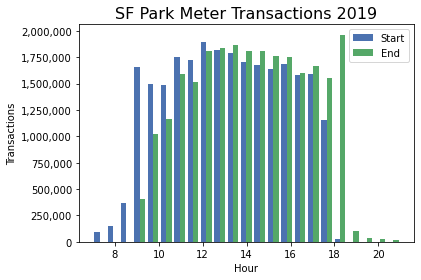

In [4]:
# park19['start_time']    = park19['start_datetime'].dt.hour  + (park19['start_datetime'].dt.minute/60)
# park19['end_time']      = park19['end_datetime'].dt.hour + (park19['end_datetime'].dt.minute/60)

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
plt.rc('ytick', labelsize=10) 
x = park19['start_time'].values
y = park19['end_time'].values
bins = np.linspace(min(x), max(y), 24)

fig, ax1 = plt.subplots()
ax1.hist([x, y], bins, label=['Start', 'End'])
ax1.set_ylabel("Transactions")
ax1.set_xlabel("Hour")

ax1.set_title('SF Park Meter Transactions 2019',fontsize=16)

import matplotlib as mpl
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.legend(loc='upper right')
plt.show()

In [1]:
import pandas as pd
import datetime as dt

path = r'C:\Users\nelms\Documents\Penn\MUSA-508\MUSA508_FINAL_SFPARK\SFMTA_Parking_Meter_Detailed_Revenue_Transactions.csv'
park19 = pd.read_csv(
    path,
    usecols=['TRANSMISSION_DATETIME', 'POST_ID', 'STREET_BLOCK', 'SESSION_START_DT', 'SESSION_END_DT', 'GROSS_PAID_AMT']
    )
park19.head()

,TRANSMISSION_DATETIME,POST_ID,STREET_BLOCK,SESSION_START_DT,SESSION_END_DT,GROSS_PAID_AMT
0,168602671_4_01022019001933,440-05850,GEARY ST 500,2019/01/02 12:19:33 AM,2019/01/02 12:19:33 AM,0.10
1,168602672_4_01022019002012,440-05170,GEARY ST 500,2019/01/02 12:20:12 AM,2019/01/02 12:20:12 AM,0.10
2,168602673_4_01022019002623,571-09070,MONTGOMERY ST 900,2019/01/02 12:26:23 AM,2019/01/02 12:26:23 AM,0.25
3,168602675_4_01022019002626,571-09070,MONTGOMERY ST 900,2019/01/02 12:26:26 AM,2019/01/02 12:26:26 AM,0.25
4,168602674_4_01022019002632,571-09070,MONTGOMERY ST 900,2019/01/02 12:26:32 AM,2019/01/02 12:26:32 AM,0.25


In [53]:
path = r'C:\Users\nelms\Documents\Penn\MUSA-508\MUSA508_FINAL_SFPARK\meter_starts_ends.parquet'
start_ends = pd.read_parquet(path)
print(len(start_ends))

74892114


,trans_id,time,action
0,102-02990_100,7.000000,interval
1,102-02990_100,9.000000,interval
2,102-02990_100,11.116667,start
3,102-02990_100,11.266667,start
4,102-02990_100,11.316667,end


In [238]:
def round_down(value, decimals):
    factor = 1 / (10 ** decimals)
    return (value // factor) * factor

#bins = [0, 7, 9, 12, 15, 18.00001, 21, 24]
bins = [0, 9, 12, 15, 18.00001, 24]
labels = [
    '12a to {}a'.format(bins[1]),    # 12 - 9?
    '{}a to {}p'.format(bins[1], round(bins[2])), # 9 - 12
    '{}p to {}p'.format(round(bins[2]), bins[3]-12), # 12 - 3
    '{}p to {}p'.format(bins[3]-12, round(bins[4])-12), # 3 - 6
    '{}p to 12a'.format(round(bins[4])-12)
    ]
good_bins = labels[1:-1]

def grouper(row, cut_off_time=9, bins=bins, labels=labels, good_bins = good_bins):
    hours_actions = row[['time','action']].values.tolist()

    use_counter = 0
    hour_counter = 0
    past_hour = 0
    past_action = ''
    keep = []
    for hour, action in hours_actions:
        if action==past_action:
            if action == 'start':
                pass
            elif action == 'end':
                pass
        elif action!=past_action:
            if action == 'end':
                if (hour == 18)or(hour == 18.0):
                    hour = 17.99999
                elif (hour == 12)or(hour == 12.0):
                    hour = 11.99999
                elif (hour == 15)or(hour == 15.0):
                    hour = 14.99999
            past_hour = hour
            past_action = action
            keep.append([hour, action])
    hours_actions = keep
    start_count = len([act for hr,act in keep if act=='start'])

    past_hour = 0
    past_action = ''
    keep = []
    for hour, action in hours_actions:
        if (action == 'interval'):
            if(past_action == 'start'):
                correct_end = hour-.00001
                # if (hour == 18)or(hour == 18.0):
                #     correct_end = 17.99999
                # if (hour == 12)or(hour == 12.0):
                #     correct_end = 11.99999
                keep.append([correct_end,'end'])
                keep.append([hour,'start'])
                past_hour = hour
                past_action = 'start'
            else:
                pass
        else:
            past_hour = hour
            past_action = action
            keep.append([hour, action])
            
    hours_actions = keep
    past_hour = 0
    past_action = ''
    keep = []
    for hour, action in hours_actions:
        if action==past_action:
            if action == 'start':
                pass
            elif action == 'end':
                pass
        elif action!=past_action:
            past_hour = hour
            past_action = action
            keep.append([hour, action])
    hours_actions = keep
    start_count = len([act for hr,act in keep if act=='start'])

    hours_actions_df = pd.DataFrame(keep, columns=['time','action']).sort_values('time').drop_duplicates()
    hours_actions_df = hours_actions_df[hours_actions_df['time']>=cut_off_time]
    #hours_actions = hours_actions_df.values.tolist()

    hours_actions_df['bins'] = pd.cut(
            hours_actions_df['time'], 
            bins, 
            labels=labels, 
            right=False, include_lowest=True
            ).astype(str)

    hours_actions_df = hours_actions_df[hours_actions_df['bins'].isin(good_bins)]

    cols = ['time','count']
    def get_times(row):
        #start_ends = row[['time', 'action']].values.tolist()
        try:
            start_ends = row[['time']].values.tolist()
            start_ends = np.reshape(start_ends, (round(len(start_ends)/2), 2))

            start_ends = [round_down(end-start,3) for start,end in start_ends]
            return pd.Series((sum(start_ends), len(start_ends)), index=cols)

        except:
            print(row[['time', 'action']].values.tolist())
            return pd.Series((99, 99), index=cols)
    #group_hours_actions_df = hours_actions_df.groupby(['bins', 'action'])['time'].apply(list) #.count()
    
    group_hours_actions_df = hours_actions_df.groupby('bins').apply(get_times) #.count()

    return group_hours_actions_df
        
    

base = 150000 - 736
page_size = 1000
test = start_ends.iloc[base:base+page_size]

result = test.groupby('trans_id').apply(grouper)[['time','count']].reset_index() 
result['trans_bins_id'] = result['trans_id'] + '_' + result['bins']
bad_filt = result['time']==99
bad_trans_bins = result[bad_filt]['trans_bins_id'].unique()
#result = result[~bad_filt]
result[['meter_id','day']] = result['trans_id'].str.split('_', expand=True)
result['day'] = result['day'].astype(int)
result = result.sort_values(['meter_id','day']).reset_index(drop=True)


[[12.0, 'start'], [12.85, 'end'], [14.99999, 'end']]
[[9.65, 'start'], [11.65, 'end'], [11.99999, 'end']]
[[9.683333333333334, 'start']]


,trans_id,bins,time,count,trans_bins_id,meter_id,day
0,103-13660_7,3p to 6p,1.233,1.0,103-13660_7_3p to 6p,103-13660,7
1,103-13660_57,12p to 3p,1.066,1.0,103-13660_57_12p to 3p,103-13660,57
2,103-13660_57,3p to 6p,1.033,1.0,103-13660_57_3p to 6p,103-13660,57
3,103-13660_57,9a to 12p,1.366,2.0,103-13660_57_9a to 12p,103-13660,57
4,103-13660_58,12p to 3p,99.000,99.0,103-13660_58_12p to 3p,103-13660,58
...,...,...,...,...,...,...,...
167,103-13680_171,3p to 6p,0.265,3.0,103-13680_171_3p to 6p,103-13680,171
168,103-13680_172,12p to 3p,0.066,1.0,103-13680_172_12p to 3p,103-13680,172
169,103-13680_172,3p to 6p,0.949,1.0,103-13680_172_3p to 6p,103-13680,172
170,103-13680_172,9a to 12p,1.833,1.0,103-13680_172_9a to 12p,103-13680,172


In [ ]:
import pandas as pd
import numpy as np

path = r'C:\Users\nelms\Documents\Penn\MUSA-508\MUSA508_FINAL_SFPARK\meter_starts_ends.parquet'
start_ends = pd.read_parquet(path, columns=['trans_id','time','action'])
print(len(start_ends['trans_id'].unique()))
# 3607812

#####################

def round_down(value, decimals):
    factor = 1 / (10 ** decimals)
    return (value // factor) * factor

#bins = [0, 7, 9, 12, 15, 18.00001, 21, 24]
bins = [0, 9, 12, 15, 18.00001, 24]
labels = [
    '12a to {}a'.format(bins[1]),    # 12 - 9?
    '{}a to {}p'.format(bins[1], round(bins[2])), # 9 - 12
    '{}p to {}p'.format(round(bins[2]), bins[3]-12), # 12 - 3
    '{}p to {}p'.format(bins[3]-12, round(bins[4])-12), # 3 - 6
    '{}p to 12a'.format(round(bins[4])-12)
    ]
good_bins = labels[1:-1]

#####################

counter = 0

def grouper(row, cut_off_time=9, bins=bins, labels=labels, good_bins = good_bins):
    hours_actions = row[['time','action']].values.tolist()

    global counter
    counter = counter + 1
    if float(counter/10000).is_integer():
        print(counter)

    past_action = ''
    keep = []
    for hour, action in hours_actions:
        if (action != 'interval')and(action==past_action):
            if action == 'start':
                pass
            elif action == 'end':
                keep.pop()
                past_hour = hour
                past_action = action
                keep.append([hour, action])
        elif action!=past_action:
            if action == 'end':
                if (hour == 18)or(hour == 18.0):
                    hour = 17.99999
                elif (hour == 12)or(hour == 12.0):
                    hour = 11.99999
                elif (hour == 15)or(hour == 15.0):
                    hour = 14.99999
            past_action = action
            keep.append([hour, action])
    hours_actions = keep
    #start_count = len([act for hr,act in keep if act=='start'])

    past_action = ''
    keep = []
    for hour, action in hours_actions:
        if (action == 'interval'):
            if(past_action == 'start'):
                correct_end = hour-.00001
                # if (hour == 18)or(hour == 18.0):
                #     correct_end = 17.99999
                # if (hour == 12)or(hour == 12.0):
                #     correct_end = 11.99999
                keep.append([correct_end,'end'])
                keep.append([hour,'start'])
                past_action = 'start'
            else:
                pass
        else:
            past_action = action
            keep.append([hour, action])
            
    hours_actions = keep
    past_action = ''
    keep = []
    for hour, action in hours_actions:
        if action==past_action:
            pass
        elif action!=past_action:
            past_hour = hour
            past_action = action
            keep.append([hour, action])
    hours_actions = keep
    #start_count = len([act for hr,act in keep if act=='start'])

    hours_actions_df = pd.DataFrame(keep, columns=['time','action']).sort_values('time').drop_duplicates()
    hours_actions_df = hours_actions_df[hours_actions_df['time']>=cut_off_time]
    #hours_actions = hours_actions_df.values.tolist()

    hours_actions_df['bins'] = pd.cut(
            hours_actions_df['time'], 
            bins, 
            labels=labels, 
            right=False, include_lowest=True
            ).astype(str)

    cols = ['time','count']
    def get_times(row):
        #start_ends = row[['time', 'action']].values.tolist()
        try:
            start_ends = row[['time']].values.tolist()
            start_ends = np.reshape(start_ends, (round(len(start_ends)/2), 2))

            start_ends = [round_down(end-start,3) for start,end in start_ends]
            return pd.Series((sum(start_ends), len(start_ends)), index=cols)

        except:
            #print(row[['time', 'action']].values.tolist())
            return pd.Series((99, 99), index=cols)
    #group_hours_actions_df = hours_actions_df.groupby(['bins', 'action'])['time'].apply(list) #.count()
    
    group_hours_actions_df = hours_actions_df[hours_actions_df['bins'].isin(good_bins)].groupby('bins').apply(get_times) #.count()

    return group_hours_actions_df

start_ends = start_ends[['trans_id','time','action']].sort_values('trans_id')
result = start_ends[['trans_id','time','action']].groupby('trans_id').apply(grouper)[['time','count']].reset_index() 
result['trans_bins_id'] = result['trans_id'] + '_' + result['bins']
bad_filt = result['time']==99
bad_trans_bins = result[bad_filt]['trans_bins_id'].unique()
#result = result[~bad_filt]
result[['meter_id','day']] = result['trans_id'].str.split('_', expand=True)
result['day'] = result['day'].astype(int)
result = result.sort_values(['meter_id','day']).reset_index(drop=True)
# got counts
print('got observed')
print(len(bad_trans_bins))


In [12]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

path = r'C:\Users\nelms\Documents\Penn\MUSA-508\MUSA508_FINAL_SFPARK\meter_starts_ends.parquet'
trans_day_actions = pd.read_parquet(path)

In [15]:
trans_day_actions[['meter_id','day']] = trans_day_actions['trans_id'].str.split('_', expand=True)

In [16]:
trans_day_actions.head()

,trans_id,time,action,day
0,102-02990_100,7.000000,interval,_
1,102-02990_100,9.000000,interval,_
2,102-02990_100,11.116667,start,_
3,102-02990_100,11.266667,start,_
4,102-02990_100,11.316667,end,_


In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

path = r'C:\Users\nelms\Documents\Penn\MUSA-508\MUSA508_FINAL_SFPARK\meter_starts_ends.parquet'
trans_day_actions = dd.read_parquet(path).set_index('trans_id') #.persist()

# #############

# unique_list = list(hours_actions_df.index.unique().compute())
# hours_actions_df = hours_actions_df.repartition(divisions=sorted(unique_list + [unique_list[-1]]))
# print(trans_day_actions.npartitions)

#################

counter = 0

def grouper(row, cut_off_time=9):
    hours_actions = row[['time','action']].values.tolist()

    global counter
    counter = counter + 1
    if float(counter/10000).is_integer():
        print(counter)

    while hours_actions[0][1] == 'interval':
        hours_actions.pop(0)

    while hours_actions[-1][1] == 'interval':
        hours_actions.pop(-1)

    past_action = ''
    keep = []
    for hour, action in hours_actions:
        if (action != 'interval')and(action==past_action):
            if action == 'start':
                pass
            elif action == 'end':
                keep.pop()
                past_hour = hour
                past_action = action
                keep.append([hour, action])
        elif action!=past_action:
            # if action == 'end':
            #     if (hour == 18)or(hour == 18.0):
            #         hour = 17.99999
            #     elif (hour == 12)or(hour == 12.0):
            #         hour = 11.99999
            #     elif (hour == 15)or(hour == 15.0):
            #         hour = 14.99999
            past_action = action
            keep.append([hour, action])
    hours_actions = keep
    #start_count = len([act for hr,act in keep if act=='start'])

    past_action = ''
    keep = []
    for hour, action in hours_actions:
        if (action == 'interval'):
            if(past_action == 'start'):
                correct_end = hour-.00001
                # if (hour == 18)or(hour == 18.0):
                #     correct_end = 17.99999
                # if (hour == 12)or(hour == 12.0):
                #     correct_end = 11.99999
                keep.append([correct_end,'end'])
                keep.append([hour,'start'])
                past_action = 'start'
            else:
                pass
        else:
            past_action = action
            keep.append([hour, action])
            
    hours_actions = keep
    past_action = ''
    keep = []
    for hour, action in hours_actions:
        if action==past_action:
            pass
        elif action!=past_action:
            past_hour = hour
            past_action = action
            keep.append([hour, action])
    #start_count = len([act for hr,act in keep if act=='start'])

    # hours_actions_df = pd.DataFrame(keep, columns=['time','action'])
    return pd.DataFrame(keep, columns=['time','action'])

#trans_day_actions = hours_actions_df.map_partitions(grouper, meta={'time': 'int64', 'action': 'str'})
trans_day_actions = trans_day_actions.groupby('trans_id')[['time','action']].apply(grouper, meta={'time': 'int64', 'action': 'str'})
trans_day_actions = trans_day_actions #.persist()

print('after function')

path = r'C:\Users\nelms\Documents\Penn\MUSA-508\MUSA508_FINAL_SFPARK\meter_trans_day_clean.parquet'
trans_day_actions.to_parquet(path)
print('exported')

after function
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
13700

In [ ]:
trans_day_actions

In [6]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

path = r'C:\Users\nelms\Documents\Penn\MUSA-508\MUSA508_FINAL_SFPARK\meter_trans_day_clean.parquet'
trans_day_actions = dd.read_parquet(path).set_index('trans_id').persist()

#############

cut_off_time = 9
trans_day_actions = trans_day_actions[trans_day_actions['time']>=cut_off_time].drop_duplicates()
trans_day_actions = trans_day_actions.persist()

trans_day_actions['bins'] = pd.cut(
            trans_day_actions['time'], 
            bins, 
            labels=labels, 
            right=False, include_lowest=True
            ).astype(str)
trans_day_actions = trans_day_actions[trans_day_actions['bins'].isin(good_bins)]
trans_day_actions['block_day_bins'] = trans_day_actions['trans_id'] + '_' + trans_day_actions['bins']
trans_day_actions = trans_day_actions[['block_day_bins', 'time']].set_index('block_day_bins')
trans_day_actions = trans_day_actions.persist()

#####

unique_list = list(trans_day_actions.index.unique().compute())
trans_day_actions = trans_day_actions.repartition(divisions=sorted(unique_list + [unique_list[-1]]))
print(trans_day_actions.npartitions)

#############

counter = 0
cols = ['time'] #,'count']
def get_times(row):
    #start_ends = row[['time', 'action']].values.tolist()

    global counter
    counter = counter + 1
    if float(counter/100000).is_integer():
        print(counter)

    try:
        start_ends = row[['time']].values.tolist()
        start_ends = np.reshape(start_ends, (round(len(start_ends)/2), 2))

        start_ends = [round_down(end-start,3) for start,end in start_ends]
        return pd.Series((sum(start_ends), len(start_ends)), index=cols)

    except:
        #print(row[['time', 'action']].values.tolist())
        return pd.Series((99, 99), index=cols)
    #group_hours_actions_df = hours_actions_df.groupby(['bins', 'action'])['time'].apply(list) #.count()

trans_day_actions = trans_day_actions.map_partitions(get_times, meta={'time': 'int64', 'action': 'str'})
#trans_day_actions = trans_day_actions.groupby('bins').apply(get_times)

#####

path = r'C:\Users\nelms\Documents\Penn\MUSA-508\MUSA508_FINAL_SFPARK\meter_trans_count.parquet'
trans_day_actions.to_parquet(path, engine='pyarrow')
print('exported')


# result['trans_bins_id'] = result['trans_id'] + '_' + result['bins']
# bad_filt = result['time']==99
# bad_trans_bins = result[bad_filt]['trans_bins_id'].unique()
# #result = result[~bad_filt]
# result[['meter_id','day']] = result['trans_id'].str.split('_', expand=True)
# result['day'] = result['day'].astype(int)
# result = result.sort_values(['meter_id','day']).reset_index(drop=True)
# # got counts
# print('got observed')
# print(len(bad_trans_bins))

# 90


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
1390

In [161]:

group_cols = ['block_day_bins','time','count']
regs['poss_time'] = 3
regs_group = regs[group_cols+['poss_time']].groupby('block_day_bins').agg(
    transactions={'count':'sum'}, 
    occ_hours={'time':'sum'}, 
    all_hours={'poss_time':'sum'}
    )
regs_group['occupancy'] = regs_group['occ_hours'] / regs_group['all_hours']

,meter_id,trans_id,block_id,bins
0,102-02990,102-02990_14,02ND AVE 200,9a to 12p
1,102-02990,102-02990_14,02ND AVE 200,12p to 3p
2,102-02990,102-02990_14,02ND AVE 200,3p to 6p
3,102-02990,102-02990_15,02ND AVE 200,9a to 12p
4,102-02990,102-02990_15,02ND AVE 200,12p to 3p
5,102-02990,102-02990_15,02ND AVE 200,3p to 6p
6,102-02990,102-02990_140,02ND AVE 200,9a to 12p
7,102-02990,102-02990_140,02ND AVE 200,12p to 3p
8,102-02990,102-02990_140,02ND AVE 200,3p to 6p
9,102-02990,102-02990_141,02ND AVE 200,9a to 12p
